In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import torch
import torchvision.transforms as transforms

from torchvision.datasets import CIFAR100, CIFAR10
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset

from medmnist import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

warnings.filterwarnings("ignore")

In [2]:
# Configurations

dataset = 'pathmnist'
img_size = 28
batch_size = 64
num_classes = 9
finetuning_epochs = 15
epochs = 100

### Note

All Datasets will be of the format (N, C, H, W) with values between 0 and 1, unless stated otherwise.

This format is easier to deal with in PyTorch.

In [3]:
srmodel = torch.load('model/model_srresnet.pth')["model"]
srmodel = srmodel.cuda()

In [4]:
def generate_sr_dataset(dataset, model):
    sr_images, sr_targets = [], []    
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, num_workers=4)
    for (inputs, targets) in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.cuda()
            inputs = Variable(inputs).float()
            sr_inputs = model(inputs)
            sr_images.append(sr_inputs.cpu().numpy().astype(np.float32))
            sr_targets.append(targets.numpy().astype(np.int64))

    sr_images = np.concatenate(sr_images, axis=0).clip(0, 1)
    sr_targets = np.concatenate(sr_targets, axis=0)

    sr_images = torch.from_numpy(sr_images)
    sr_targets = torch.from_numpy(sr_targets)
    sr_dataset = TensorDataset(sr_images, sr_targets)
    return sr_dataset

In [5]:
def get_dataset(dataset, transform):
    if dataset == 'pathmnist':
        train_dataset = PathMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = PathMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = PathMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'chestmnist':
        train_dataset = ChestMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = ChestMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = ChestMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'dermamnist':
        train_dataset = DermaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = DermaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = DermaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'octmnist':
        train_dataset = OCTMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = OCTMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = OCTMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'pneumoniamnist':
        train_dataset = PneumoniaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = PneumoniaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = PneumoniaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'retinamnist':
        train_dataset = RetinaMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = RetinaMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = RetinaMNIST(root='data', split='test', transform=transform, download=True)
    elif dataset == 'breastmnist':
        train_dataset = BreastMNIST(root='data', split='train', transform=transform, download=True)
        val_dataset = BreastMNIST(root='data', split='val', transform=transform, download=True)
        test_dataset = BreastMNIST(root='data', split='test', transform=transform, download=True)
    else:
        raise ValueError('Wrong dataset name!')
    return train_dataset, val_dataset, test_dataset

In [6]:
# trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
# testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

lr_trainset, lr_valset, lr_testset = get_dataset(dataset, transforms.ToTensor())

sr_trainset = generate_sr_dataset(lr_trainset, srmodel)
sr_valset = generate_sr_dataset(lr_valset, srmodel)
sr_testset = generate_sr_dataset(lr_testset, srmodel)

Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz


  0%|          | 0/176 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
bc_transform = transforms.Compose([
    transforms.Resize((4*img_size, 4*img_size), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

bc_trainset, bc_valset, bc_testset = get_dataset(dataset, bc_transform)

Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz
Using downloaded and verified file: data/pathmnist.npz


In [8]:
lr_trainloader = DataLoader(lr_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
lr_valloader = DataLoader(lr_valset, batch_size=batch_size, shuffle=False, num_workers=4)
lr_testloader = DataLoader(lr_testset, batch_size=batch_size, shuffle=False, num_workers=4)

sr_trainloader = DataLoader(sr_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
sr_valloader = DataLoader(sr_valset, batch_size=batch_size, shuffle=False, num_workers=4)
sr_testloader = DataLoader(sr_testset, batch_size=batch_size, shuffle=False, num_workers=4)

bc_trainloader = DataLoader(bc_trainset, batch_size=batch_size, shuffle=False, num_workers=4)
bc_valloader = DataLoader(bc_valset, batch_size=batch_size, shuffle=False, num_workers=4)
bc_testloader = DataLoader(bc_testset, batch_size=batch_size, shuffle=False, num_workers=4)

torch.Size([64, 3, 28, 28]) torch.Size([64, 1])


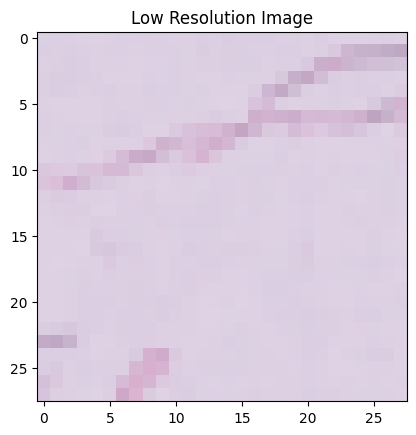

In [9]:
for i, (inputs, targets) in enumerate(lr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Low Resolution Image')
    plt.show()
    break

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


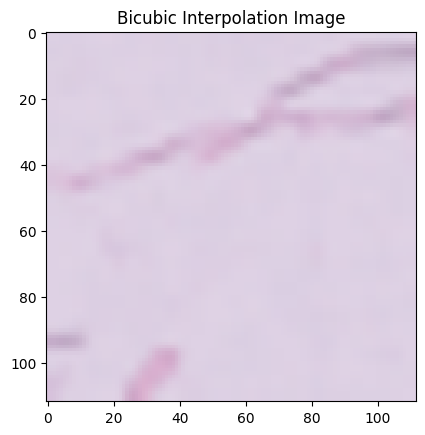

In [10]:
for i, (inputs, targets) in enumerate(bc_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Bicubic Interpolation Image')
    plt.show()
    break

torch.Size([64, 3, 112, 112]) torch.Size([64, 1])


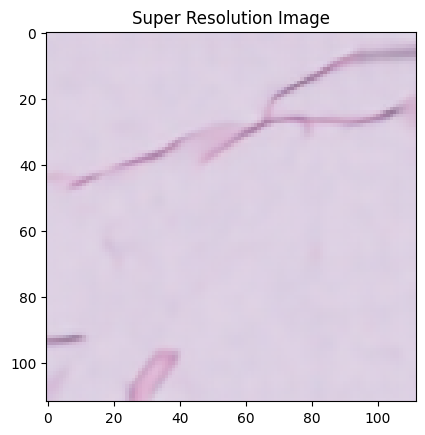

In [11]:
for i, (inputs, targets) in enumerate(sr_trainloader):
    print(inputs.shape, targets.shape)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title('Super Resolution Image')
    plt.show()
    break

### Training a CNN

In [12]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def create_model(pretrain=True, out_channels=10):
    model = models.resnet18(pretrained=pretrain)
    model.fc = torch.nn.Linear(512, out_channels)
    model = model.cuda()
    return model

def train(model, trainloader, valloader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    accuracy = []
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader):
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        correct = 0
        total = 0
        with torch.no_grad():
            for (inputs, targets) in valloader:
                inputs = inputs.cuda()
                targets = targets.squeeze().cuda()
                inputs = Variable(inputs).float()
                targets = Variable(targets).long()
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        print(f'Accuracy of the network on the val images: {(100 * correct / total):.2f} %')
        print('Loss on train set: ', running_loss / len(trainloader))
        accuracy.append(correct / total)
    return accuracy

def test(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs = inputs.cuda()
            targets = targets.squeeze().cuda()
            inputs = Variable(inputs).float()
            targets = Variable(targets).long()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    print(f'Accuracy of the network on the test images: {(100 * correct / total):.2f} %')

In [14]:
model = create_model(True, num_classes)
lr_val_acc = train(model, lr_trainloader, lr_valloader , epochs=finetuning_epochs)
test(model, lr_testloader)

torch.save(model.state_dict(), f'model/model_lr_finetune15_{dataset}.pth')

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy of the network on the val images: 89.61 %
Loss on train set:  0.4679888556390344
Accuracy of the network on the val images: 90.69 %
Loss on train set:  0.22876590540647168
Accuracy of the network on the test images: 80.72 %


In [15]:
model = create_model(True, num_classes)
bc_val_acc = train(model, bc_trainloader, bc_valloader , epochs=finetuning_epochs)
test(model, bc_testloader)

torch.save(model.state_dict(), f'model/model_bc_finetune15_{dataset}.pth')

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy of the network on the val images: 95.60 %
Loss on train set:  0.26638350585461


In [ ]:
model = create_model(True, num_classes)
sr_val_acc = train(model, sr_trainloader, sr_valloader, epochs=finetuning_epochs)
test(model, sr_testloader)

torch.save(model.state_dict(), f'model/model_sr_finetune15_{dataset}.pth')

In [ ]:
plt.plot(lr_val_acc, label='LR')
plt.plot(bc_val_acc, label='bicubic')
plt.plot(sr_val_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title(f'Finetuning performance on {dataset}')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'./finetune_{dataset}.png')

In [ ]:
model = create_model(False, num_classes)
lr_val_acc = train(model, lr_trainloader, lr_valloader, epochs=epochs)
test(model, lr_testloader)

torch.save(model.state_dict(), f'model/model_lr_scratch100_{dataset}.pth')

In [ ]:
model = create_model(False, num_classes)
bc_val_acc = train(model, bc_trainloader, bc_valloader, epochs=epochs)
test(model, bc_testloader)

torch.save(model.state_dict(), f'model/model_bc_scratch100_{dataset}.pth')

In [ ]:
model = create_model(False, num_classes)
sr_val_acc = train(model, sr_trainloader, sr_valloader, epochs=epochs)
test(model, sr_testloader)

torch.save(model.state_dict(), f'model/model_sr_scratch100_{dataset}.pth')

In [ ]:
plt.plot(lr_val_acc, label='LR')
plt.plot(bc_val_acc, label='bicubic')
plt.plot(sr_val_acc, label='srresnet')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training performance on {dataset}')
plt.legend()
plt.grid()
plt.show()
plt.savefig(f'./train_{dataset}.png')